This notebook serves to update the figures in the paper

In [ ]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 26}
mpl.rc('font', **font)

import os
os.environ["PATH"] = "/usr/local/texlive/2025/bin/universal-darwin:" + os.environ["PATH"]

import numpy as np
from astropy.cosmology import Planck18, z_at_value
cosmo = Planck18
from scipy import integrate
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pickle, os

import h5py
import astropy.units as u

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

class MulticolorPatchHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        colors = getattr(orig_handle, 'colors', ['gray'])
        n = len(colors)
        return [Rectangle((x0 + i * width / n, y0), width / n, height,
                          transform=trans, facecolor=color, edgecolor='black') for i, color in enumerate(colors)]
    
class MulticolorPatchHandler(HandlerBase):
    def __init__(self, width_scale=1.3, height_scale=1.5, **kwargs):
        super().__init__(**kwargs)
        self.width_scale = width_scale
        self.height_scale = height_scale

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        colors = getattr(orig_handle, 'colors', ['gray'])
        n = len(colors)

        # Scale width and height
        patch_width = width * self.width_scale
        patch_height = height * self.height_scale
        start_x = x0 - (patch_width - width) / 2
        start_y = y0 - (patch_height - height) / 2

        return [
            Rectangle(
                (start_x + i * patch_width / n, start_y),
                patch_width / n,
                patch_height,
                transform=trans,
                facecolor=color,
                edgecolor='black'
            )
            for i, color in enumerate(colors)
        ]


class MulticolorPatchHandler(HandlerBase):
    def __init__(self, width_scale=1.3, height_scale=1.5, hatches=None, **kwargs):
        super().__init__(**kwargs)
        self.width_scale = width_scale
        self.height_scale = height_scale
        self.hatches = hatches or []
        
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        colors = getattr(orig_handle, 'colors', ['gray'])
        n = len(colors)

        # Scale width and height
        patch_width = width * self.width_scale
        patch_height = height * self.height_scale
        start_x = x0 - (patch_width - width) / 2
        start_y = y0 - (patch_height - height) / 2

        return [
            Rectangle(
                (start_x + i * patch_width / n, start_y),
                patch_width / n,
                patch_height,
                transform=trans,
                facecolor=color,
                edgecolor='black',
                hatch=self.hatches[i] if i < len(self.hatches) else None
            )
            for i, color in enumerate(colors)
        ]


In [5]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


In [6]:
cosmo = Planck18# Define temporary cosmology for volume calculation
tot_sky = 41253. # Total square degrees in the sky

halo_model = "SMT"

mmin = 3 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

baryon_frac = 0.16 # from Planck18
c = 'orange'

In [7]:
cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
df0 = pd.read_csv('data/AC_117560.txt', names = cols, sep = '\s+')
df1 = pd.read_csv('data/AC_109760.txt', names = cols, sep = '\s+')
df2 = pd.read_csv('data/AC_55410.txt', names = cols, sep = '\s+') 

text_names = [r'$\mathrm{PRIMER-EXCELS-117560}$', r'$\mathrm{PRIMER-EXCELS-109760}$', r'$\mathrm{ZF-UDS-7329}$']
title_names = [r'$\mathrm{117560}$ ', r'$\mathrm{109760}$ ', r'$\mathrm{7329}$ ']

df0 = df0[df0['t']>0.15]
df1 = df1[df1['t']>0.15]
df2 = df2[df2['t']>0.15]
## transfer time into redshift - somewhat slow
z_AC0 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df0['t']])
z_AC1 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df1['t']])
z_AC2 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df2['t']])

In [20]:
def plotax(ax, zs, meds, sig1s, sig2s, sig3s = None, xlabel = True, d=0, ylabel = True, c='orange', survey = 'GS-55410 ', ty = 'SED-fitting', filter_size = 0.1, xmin = 3.2, log = False, leg = False, met = '', med_label = False, hatch = None, a_extra = 1):
    if log:
        meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )
    if c == 'b' or c == 'royalblue':
        med_color = 'darkblue'
    elif c == 'red':
        med_color = 'darkred'
    elif c =='grey':
        med_color = 'darkslategrey' 
    else:
        med_color = 'k'
    if med_label:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, label = r'$\mathrm{Median}$', zorder = 10)
    else:
        ax.plot(zs, np.array(meds)-d, c = med_color, linestyle = 'dashed', linewidth=4, zorder = 10)
        
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.3*a_extra, label = r'1$\sigma$'+met, hatch=hatch)
    
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.2*a_extra, label = r'2$\sigma$'+met, hatch=hatch)
    if np.any(sig3s):
        ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.1*a_extra, label = r'3$\sigma$'+met, hatch=hatch)
    
    ax.grid(visible = True,alpha=0.3)
    if ty:
        ax.set(title = f'{survey}{ty}', ylim = (9,11.65), xlim = (xmin,12.4))
    else:
        ax.set(ylim = (8,11.8), xlim = (3.2,12.4))
        
    if ylabel:
        # ax.set(ylabel = r'$\mathrm{Stellar~mass}$ [$\mathrm{log}(M_*/M_{\odot})$]')
        ax.set(ylabel = r'$\mathrm{M_{*,max}}$ [$\mathrm{log}(M_*/M_{\odot})$]')

    if xlabel:
        ax.set(xlabel=r'$\mathrm{z}$')

    if leg:
        ax.legend(ncol=2, fontsize = 16, loc = 'lower left', columnspacing=0.5)

    return ax

/var/folders/7n/5d661fr13pz2l_3q38y38nz80000gn/T/ipykernel_47922/1608469205.py:3: RuntimeWarning: divide by zero encountered in log10
  meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )


['$\\mathrm{Median}$', '1$\\sigma$$\\mathrm{~SED~fit}$', '2$\\sigma$$\\mathrm{~SED~fit}$', '1$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(Environment)}$', '2$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(Environment)}$', '3$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(Environment)}$', '$\\mathrm{Medians,~\\epsilon_*=1}$', '$\\mathrm{EVS~median}$']
['$\\mathrm{Median}$', '1$\\sigma$$\\mathrm{~SED~fit}$', '2$\\sigma$$\\mathrm{~SED~fit}$', '$\\mathrm{M_{*}~at~z_{obs}~(Data)}$', '1$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(No~environment)}$', '2$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(No~environment)}$', '3$\\sigma$ $\\mathrm{M_{*,\\mathrm{max}}~(No~environment)}$', '$\\mathrm{Medians,~\\epsilon_*=1}$', '$\\mathrm{Medians,~\\epsilon_* = 0.051+0.024\\cdot(z-4)}$', '$\\mathrm{Medians,~\\epsilon_*=1}$']
['$\\mathrm{M_{*}~at~z_{obs}~(Data)}$', '$\\mathrm{Medians,~\\epsilon_* = 0.051+0.024\\cdot(z-4)}$', '$\\mathrm{Medians,~\\epsilon_*=1}$', '1$\\sigma$$\\mathrm{~SED~fit}$', '2$\\sigma$$\\mathrm{~SED~fit}$', '1

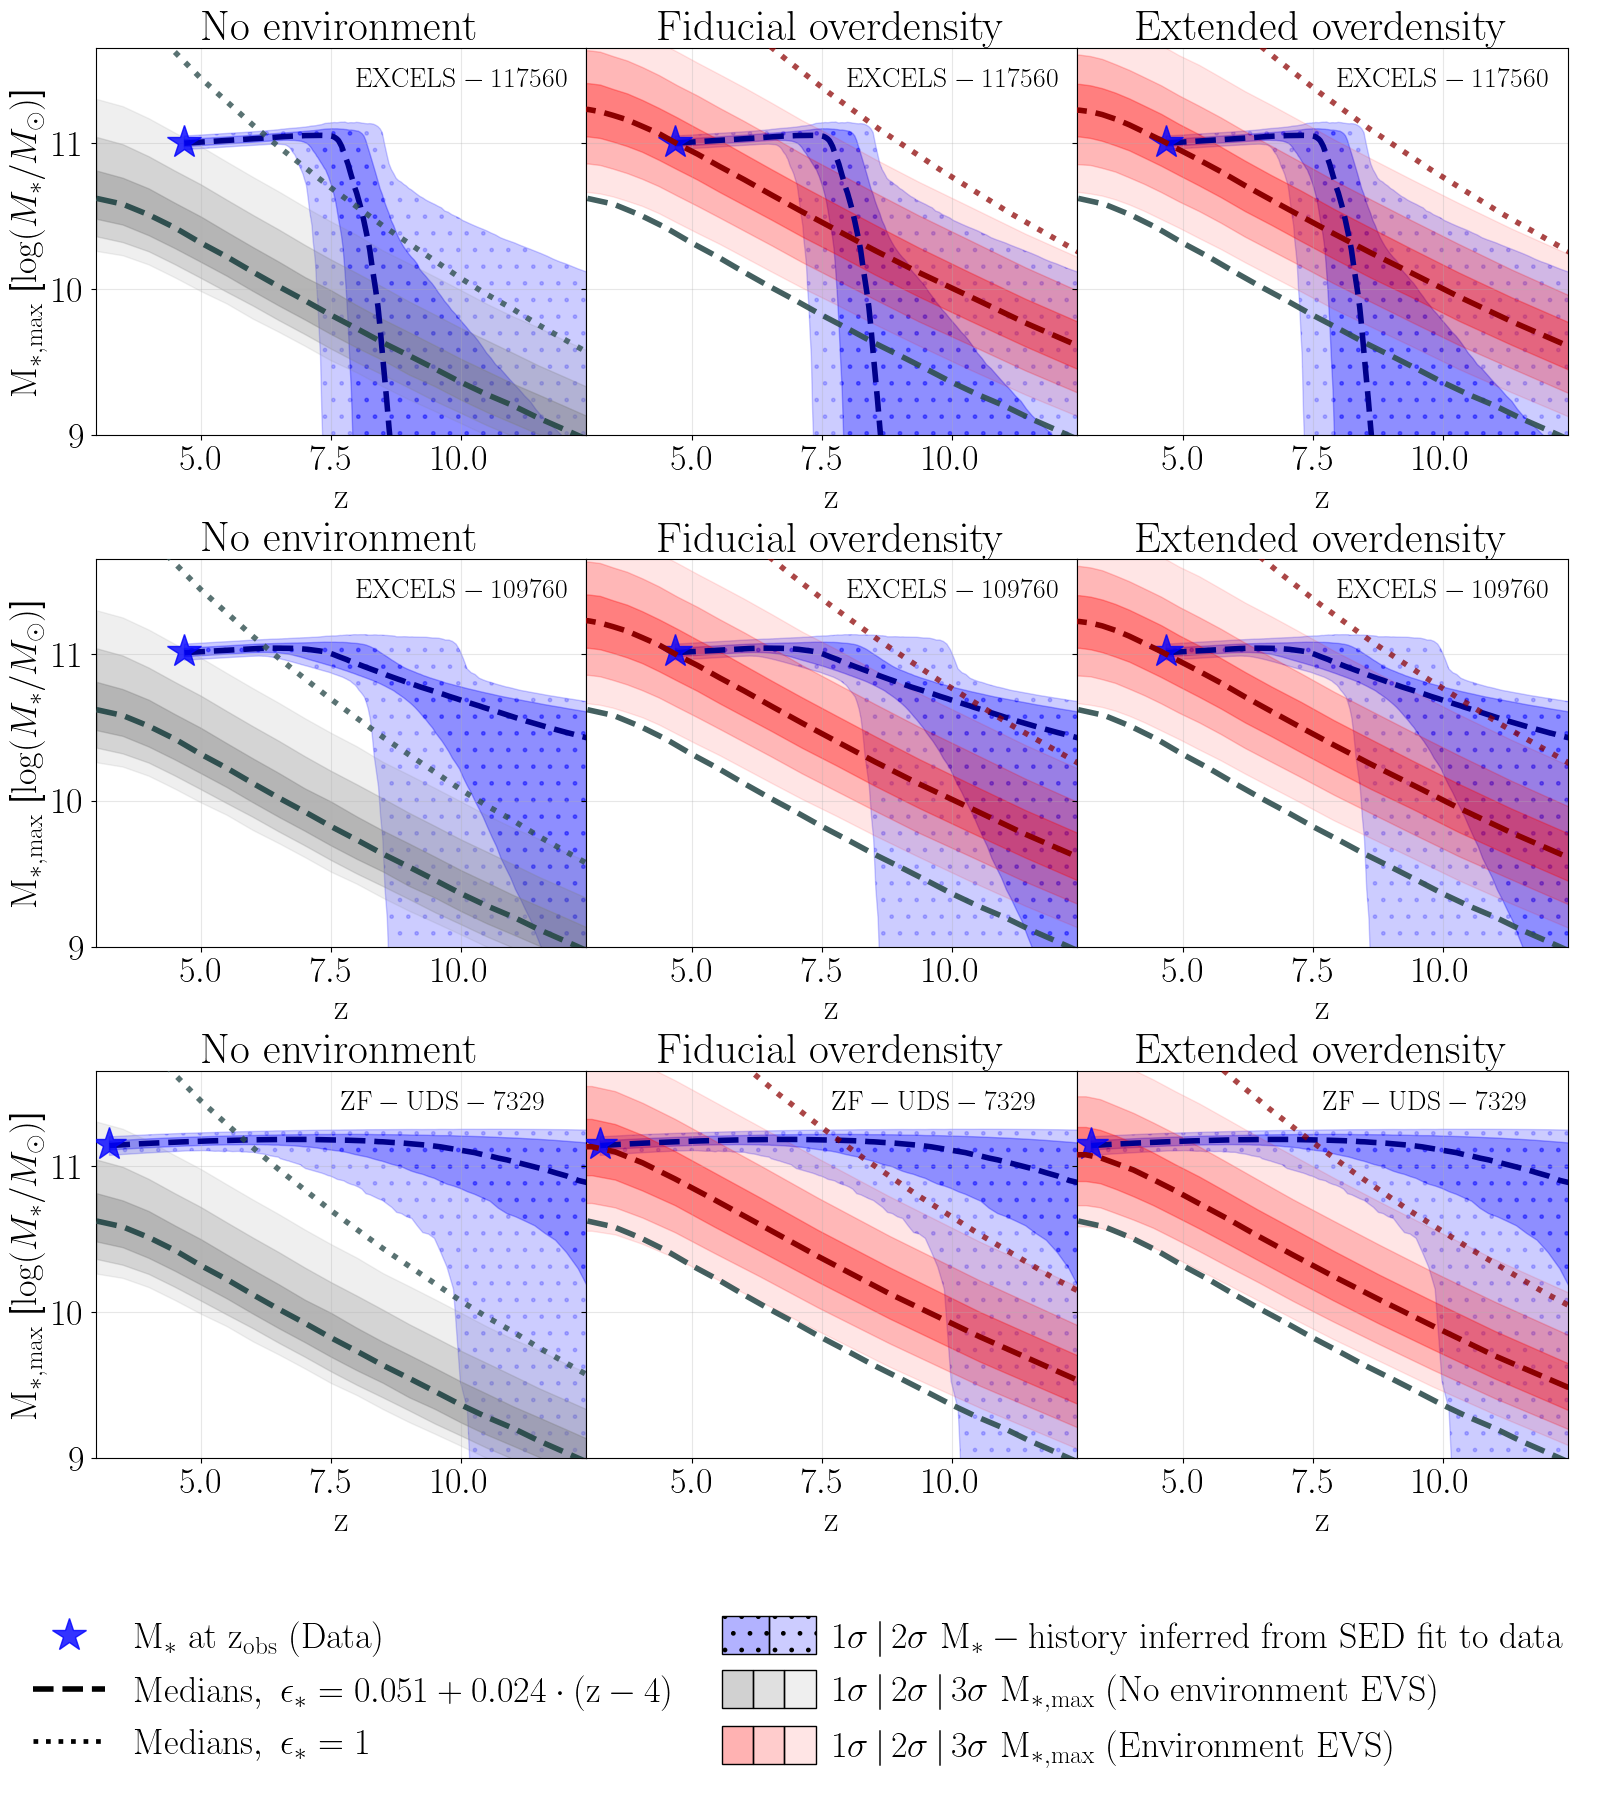

In [60]:
from evstats.evs import _apply_fsky
from evstats.stats import compute_conf_ints

text_names = [r'$\mathrm{EXCELS-117560}$', r'$\mathrm{EXCELS-109760}$', r'$\mathrm{ZF-UDS-7329}$']

fig, axss = plt.subplots(nrows = 3, ncols = 3, figsize = (19, 20), sharey = True)
axs = axss[0]
fdiv = 1.09
hatch_SED = '.'
cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
plt.subplots_adjust(wspace = 0.0, hspace = 0.32) 
c_SED = 'b'
c_sed = 'royalblue'
SEDlabel = r'$\mathrm{~SED~fit}$'

msize = 25
astar = 0.8
z0 = 10
for idx, df, z_AC in zip([0, 1, 2], [df0, df1, df2], [z_AC0, z_AC1, z_AC2]):
    axs = axss[idx]
    plotax(axs[0], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, log = True, c = c_SED, xmin = np.min(z_AC)/fdiv, survey = title_names[idx], met = SEDlabel, med_label = True, hatch = hatch_SED)
    plotax(axs[1], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC)/fdiv, survey = title_names[idx], met = SEDlabel, med_label = True , hatch = hatch_SED )
    plotax(axs[2], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T,  ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC)/fdiv, survey = title_names[idx], met = SEDlabel, med_label = True, hatch = hatch_SED  )
    if idx == 0:
        lab = r'$\mathrm{M_{*}~at~z_{obs}~(Data)}$'
    else:
        None

    axs[0].plot(z_AC[0], np.log10(df['m2'].iloc[0])+0.01, color = c_SED, marker = '*', markersize = msize, zorder = z0, alpha = astar, label = lab, linestyle = '')
    axs[1].plot(z_AC[0], np.log10(df['m2'].iloc[0])+0.01, color = c_SED, marker = '*', markersize = msize, zorder = z0, alpha = astar, linestyle = '')
    axs[2].plot(z_AC[0], np.log10(df['m2'].iloc[0])+0.01, color = c_SED, marker = '*', markersize = msize, zorder = z0, alpha = astar, linestyle = '')

cs = ['red', 'red', 'grey']
c_EVS = 'green'
titles = [[r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$'], 
          [r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$'], 
          [r'$\mathrm{Fiducial~overdensity}$', r'$\mathrm{Extended~overdensity}$']]
sbf1_title = r'$\mathrm{Medians,~\epsilon_*=1}$'
ODs = ['highz', 'highz', 'lowz']
sizes = ['small', 'big']
lw1 = 4
alpha1 = 0.8
d0 = 0.05
d0_EVS = 0.3

for j, OD in enumerate(ODs):
    axs = axss[j]
    for i, size in enumerate(sizes):
        
        with h5py.File(f'../evstats/data/{OD}_{size}_OD_fast_0.h5','r') as hf: 
            log10m = hf['log10m'][:]
            if j*i == 2:
                log10m-=0.05
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
        zs = z
        meds_cdf = CIs[:,3]
        sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
        sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
        sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

        # Create the new z array
        zs = np.insert(z, 0, z[0] / fdiv)

        # Duplicate the first row/entry of each array
        meds_cdf = np.insert(CIs[:, 3], 0, CIs[0, 3])

        sig1s = np.vstack([
            CIs[0, [2, 4]],  # duplicate first row
            CIs[:, [2, 4]]
        ])

        sig2s = np.vstack([
            CIs[0, [1, 5]],
            CIs[:, [1, 5]]
        ])

        sig3s = np.vstack([
            CIs[0, [0, 6]],
            CIs[:, [0, 6]]
        ])

        plotax(axs[i+1], zs, meds_cdf, sig1s, sig2s, sig3s = sig3s, d = -d0, ylabel = False, survey = titles[j][i], ty = ' ', c = cs[i], xmin = np.min(z_AC)/fdiv, met = r' $\mathrm{M_{*,\mathrm{max}}~(Environment)}$', a_extra = 1.0)
        
        with h5py.File(f'../evstats/data/{OD}_{size}_OD_fast_0_SBF1.h5','r') as hf:
            log10m = hf['log10m'][:]
            if j*i == 2:
                log10m-=0.1
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
        zs = z
        meds_cdf_sbf1 = CIs[:,3]

        axs[i+1].plot(zs, np.array(meds_cdf_sbf1), c = 'darkred', linestyle = 'dotted', alpha = alpha1/1.1, linewidth = lw1, label = sbf1_title, zorder = 100)
        
        # axs[i].legend(ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)
        # legend = axs[i].get_legend()
        # handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
        # # Reorder: Move last element to second position
        # handles = [handles[0], handles[-1]] + handles[1:-1]
        # labels = [labels[0], labels[-1]] + labels[1:-1]
        # handles0 = np.copy(handles)
        # labels0 = np.copy(labels)
        # handles.insert(4, plt.Line2D([0], [0], color='none'))
        # labels.insert(4, "")
        # axs[i].legend(handles, labels, ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)

    with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    # with h5py.File(os.path.expanduser('data/evs_all.h5'),'r') as hf:

        log10m_EVS = hf['log10m'][:]
        f = hf['f'][:]
        F = hf['F'][:]
        N = hf['N'][:]
        zs_EVS = hf['z'][:]

    whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
    survey_area = 160 * u.arcmin**2
    fsky = float(survey_area / whole_sky)
    phi_max0 = _apply_fsky(N, f, F, fsky)
    meds_cdf = []
    meds_cdf_sbf1 = []
    sig1s = []
    sig2s = []
    sig3s = []
    for k in range(len(zs_EVS)):

        z0 = zs_EVS[k]
        sbf = 0.051+0.024*(z0-4)

        M0 = log10m_EVS+np.log10(baryon_frac)

        cdf, CIs = compute_conf_intervals(phi_max0[k], M0)

        meds_cdf_sbf1.append(CIs[3])

        # meds_cdf_sbf1.append(M0[np.argmin(abs(cdf-0.5))])

        M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)
        cdf, CIs = compute_conf_intervals(phi_max0[k], M1)

        meds_cdf.append(CIs[3])
        sig1s.append(np.vstack([CIs[2], CIs[4]]).T)
        sig2s.append(np.vstack([CIs[1], CIs[5]]).T)
        sig3s.append(np.vstack([CIs[0], CIs[6]]).T)

        # cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
        # meds_cdf.append(M1[np.argmin(abs(cdf-0.5))])
        # sig1s.append([M1[np.argmin(abs(cdf-norm.cdf(-1)))], M1[np.argmin(abs(cdf-norm.cdf(1)))]])
        # sig2s.append([M1[np.argmin(abs(cdf-norm.cdf(-2)))], M1[np.argmin(abs(cdf-norm.cdf(2)))]])
        # sig3s.append([M1[np.argmin(abs(cdf-norm.cdf(-3)))], M1[np.argmin(abs(cdf-norm.cdf(3)))]])
    i = i+1
    plotax(axs[0], zs_EVS, meds_cdf, sig1s, sig2s, sig3s = sig3s, d=d0_EVS, ylabel = False, survey = r'$\mathrm{No~environment}$', ty = ' ', c = cs[i], xmin = np.min(z_AC)/fdiv, met = r' $\mathrm{M_{*,\mathrm{max}}~(No~environment)}$', a_extra = 1.2)

    axs[0].plot(zs_EVS, np.array(meds_cdf_sbf1)-d0_EVS,  c = 'darkslategrey', linestyle = 'dotted', alpha = 0.8, linewidth = lw1, label = sbf1_title, zorder = 100)

    axs[1].plot(zs_EVS, np.array(meds_cdf)-d0_EVS,  c = 'darkslategrey', linestyle = 'dashed', alpha = 0.9, linewidth = 4, label = r'$\mathrm{EVS~median}$')
    axs[2].plot(zs_EVS, np.array(meds_cdf)-d0_EVS,  c = 'darkslategrey', linestyle = 'dashed', alpha = 0.9, linewidth = 4, label = r'$\mathrm{EVS~median}$')

    t2 = r'$\mathrm{Medians~(Finkelstein~et~al.~2015~\epsilon_* )}$'
    t2 = r'$\mathrm{Medians,~\epsilon_* = 0.051+0.024\cdot(z-4)}$'
    axs[0].plot(zs_EVS-100, np.array(meds_cdf)-d0_EVS,  c = 'k', linestyle = 'dashed', alpha = 1, linewidth = 4, label = t2)
    axs[0].plot(zs_EVS-100, np.array(meds_cdf)-d0_EVS,  c = 'k', linestyle = 'dotted', alpha = 1, linewidth = 3.4, label = sbf1_title)



    # axs[i].legend(ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)
    # legend = axs[i].get_legend()
    # handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
    # # Reorder: Move last element to second position
    # handles = [handles[0], handles[-1]] + handles[1:-1]
    # labels = [labels[0], labels[-1]] + labels[1:-1]
    # handles.insert(4, plt.Line2D([0], [0], color='none'))
    # labels.insert(4, "")
    # axs[i].legend(handles, labels, ncol=2, fontsize = 15, loc = 'lower left', columnspacing=0.4)

for i in range(3):
    for j in range(3):
        name = text_names[i]
        x0 = 0.53
        if i == 2:
            x0 = 0.5
        axss[i][j].annotate(name, xy = (x0,0.9), xycoords = 'axes fraction', fontsize = 20)

# fig.suptitle(r'$\mathrm{Most~massive~galaxies~in~different~overdensities}$', y = 0.93)

idx_unique = np.array([0, -1, 1, 2, -4, -3, -2, 3, 4, 5])

idx_unique = np.array([-2, -1, 1, 2, 10, 11, 12, 3, 4, 5])

idx_unique = np.array([-7, -2, -1, 1, 2, 12, 13, 14, 3, 4, 5])

handles0, labels0 = axss[0][0].get_legend_handles_labels()
handles, labels = axss[2][2].get_legend_handles_labels()
print(labels)
print(labels0)
handles += handles0
labels += labels0
# Place a single legend under all subplots

# handles = list(np.array(handles)[idx_unique])
# handles.insert(2, plt.Line2D([0], [0], color='none'))
# handles.insert(5, plt.Line2D([0], [0], color='none'))

# labels = list(np.array(labels)[idx_unique])
# labels.insert(2, "")
# labels.insert(5, "")

handles = list(np.array(handles)[idx_unique])
labels = list(np.array(labels)[idx_unique])

print(labels)

i0 = 1
multicolor_idxs = [2+i0, 3+i0]  # Adapt to the correct indices
# Get facecolors (assumes these are matplotlib.patches.Patch or similar)
colors = [handles[i].get_facecolor() for i in multicolor_idxs]
from matplotlib.patches import Rectangle
# Dummy handle

multi_patch1 = Rectangle((0, 0), 1, 1)
multi_patch1.colors = [handles[i].get_facecolor() for i in [2+i0, 3+i0]]

multi_patch2 = Rectangle((0, 0), 1, 1)
multi_patch2.colors = [handles[i].get_facecolor() for i in [4+i0, 5+i0, 6+i0]]

multi_patch3 = Rectangle((0, 0), 1, 1)
multi_patch3.colors = [handles[i].get_facecolor() for i in [7+i0, 8+i0, 9+i0]]

# Insert them into your handle list at desired positions
handles[2+i0] = multi_patch1
labels[2+i0] = r'$~1\sigma\,|\,2\sigma~\mathrm{M_{*}-history~inferred~from~SED~fit~to~data}$'

handles[3+i0] = multi_patch2
labels[3+i0] = r'$~1\sigma\,|\,2\sigma\,|\,3\sigma~\mathrm{M_{*,\mathrm{max}}~(No~environment~EVS)}$'

handles[4+i0] = multi_patch3
labels[4+i0] = r'$~1\sigma\,|\,2\sigma\,|\,3\sigma~\mathrm{M_{*,\mathrm{max}}~(Environment~EVS)}$'

handles = handles[:5+i0]
labels = labels[:5+i0]

# handles.insert(2, plt.Line2D([0], [0], color='none'))
# labels.insert(2, "")

# Build handler_map dynamically
custom_handles = [multi_patch1, multi_patch2, multi_patch3]
handler_map = {h: MulticolorPatchHandler(hatches = hatches) for h, hatches in zip(custom_handles, [['.', '.'], [], [] ])}


fig.legend(np.array(handles), np.array(labels), loc='lower center', ncol=2, fontsize=26, columnspacing=1.6, frameon=False, handler_map = handler_map)

# Adjust the layout to make space for the legend
plt.subplots_adjust(bottom=0.175)


In [77]:
np.savetxt('../../../evs_clustering/dfs/second_gal.csv', np.vstack([z_AC1, df1['m0'], df1['m1'], df1['m2'], df1['m3'], df1['m4']]).T, delimiter = ',', fmt='%.4f')

In [61]:
# Adjust the bottom row (row index 2) downward
for ax in axss[2, :]:  # Iterate over all columns in the bottom row
    pos = ax.get_position()  # Get the original position
    ax.set_position([pos.x0, pos.y0 - 0.03, pos.width, pos.height])  # Shift downward

plt.show()

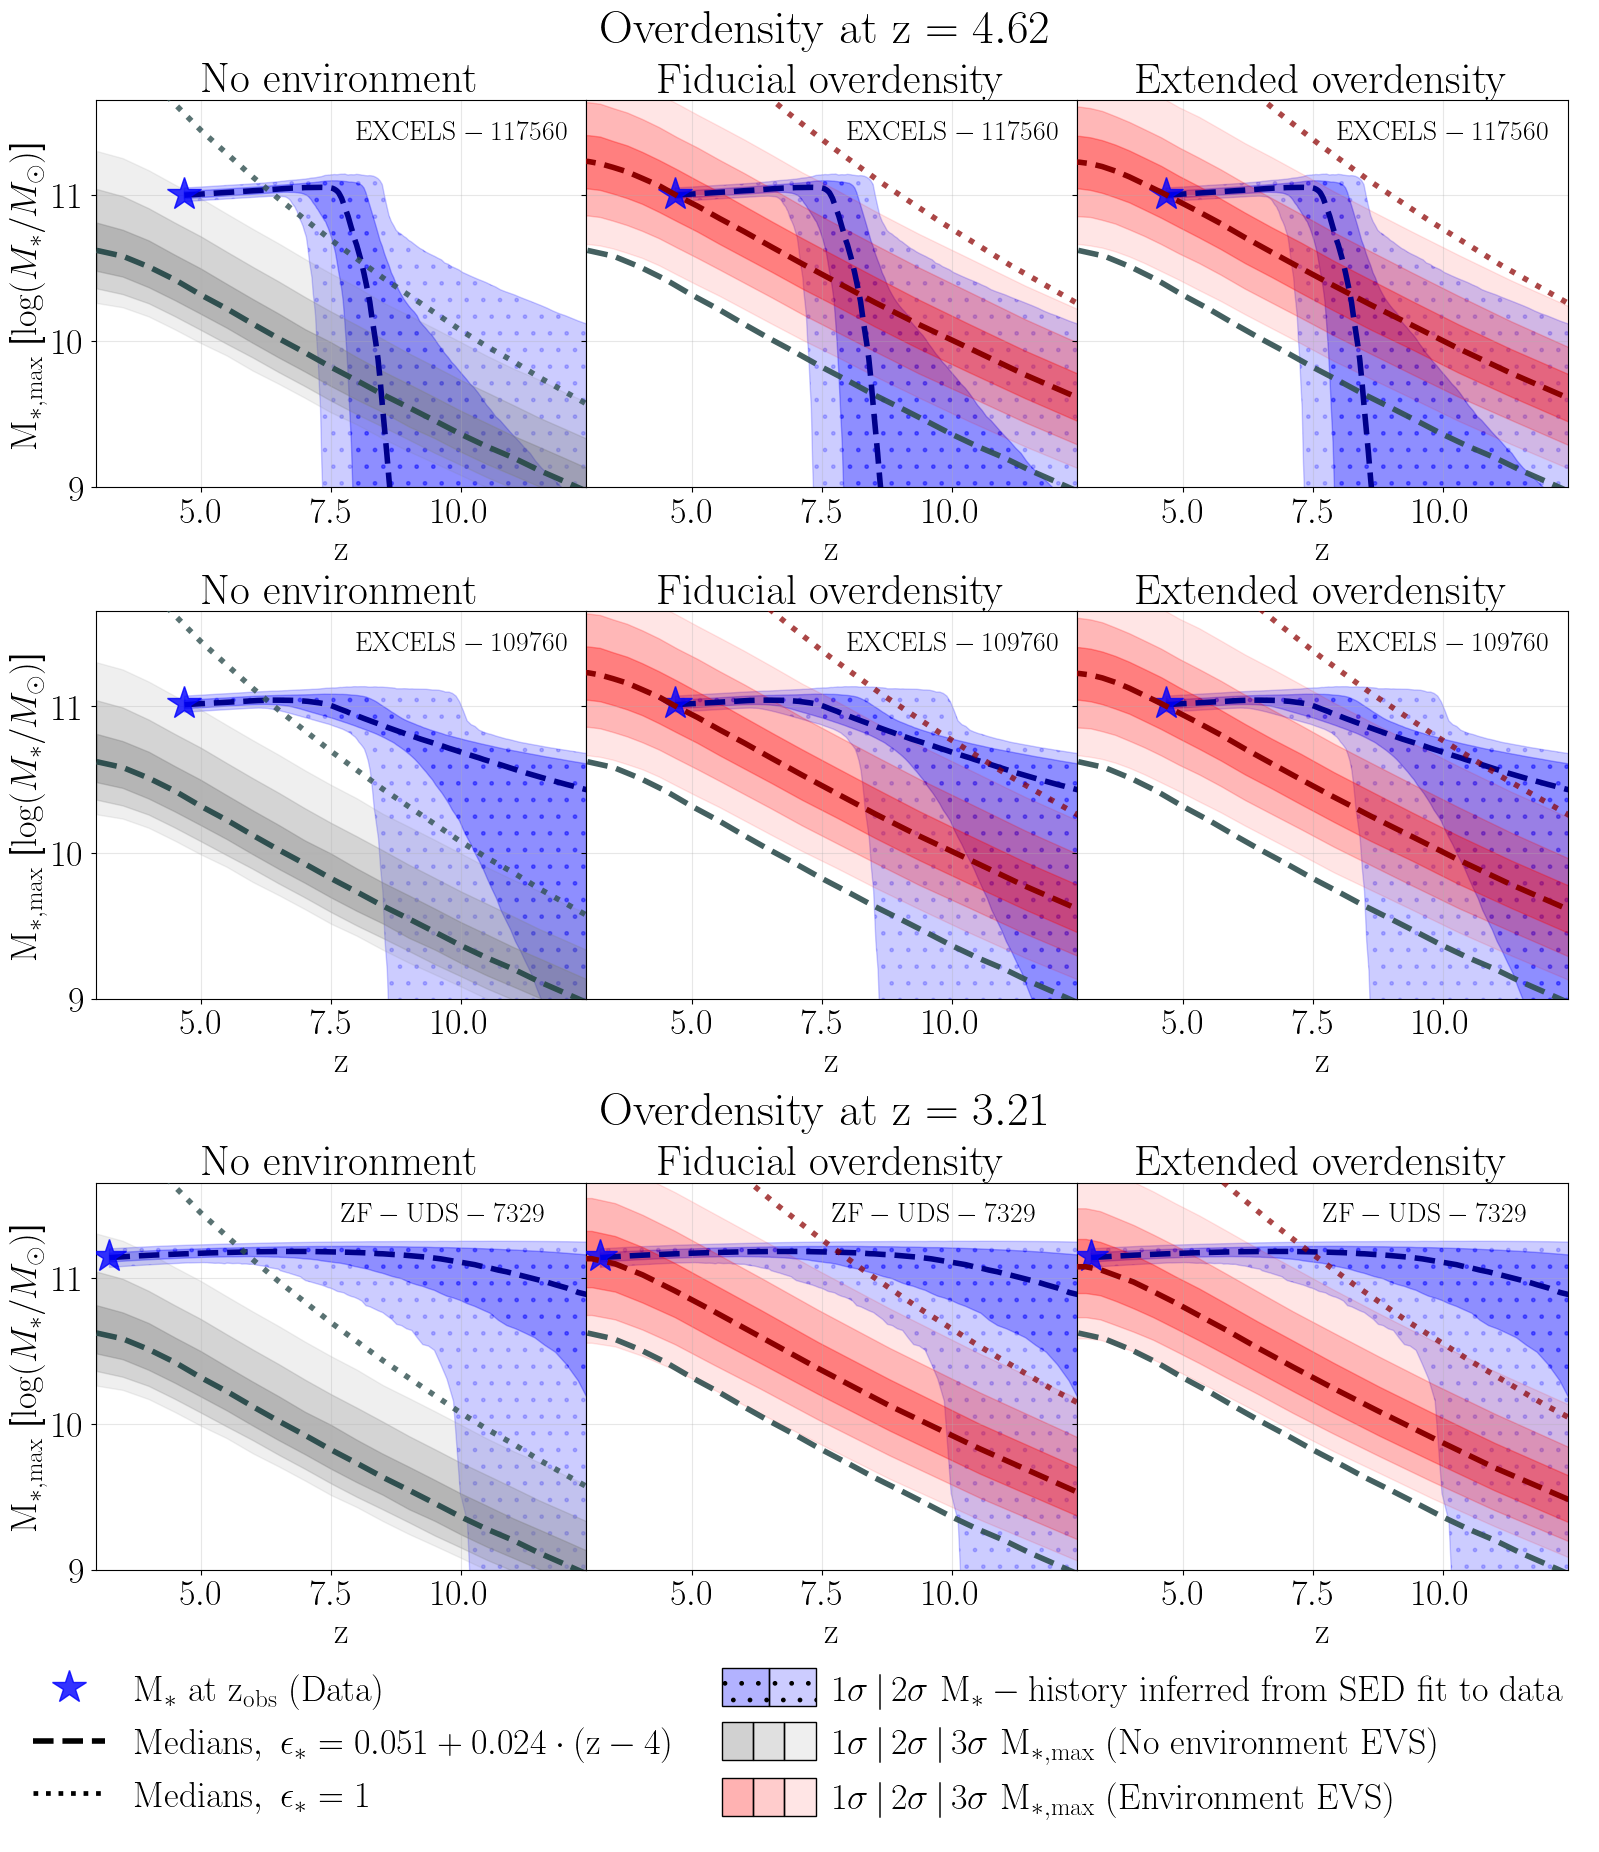

In [62]:
axss[0][1].annotate(r'$\mathrm{Overdensity~at~z = 4.62}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)
axss[2][1].annotate(r'$\mathrm{Overdensity~at~z = 3.21}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)
# plt.subplots_adjust(bottom=0.14)
fig

In [63]:
fig.savefig('paper/combined_updated_SBF_Finkelstein_fiducial_legend_reverse_order_referee_v2.png', bbox_inches = 'tight', dpi = 200)

Here we calculate the maximum discrepancy

In [163]:
df = df0
z_AC = z_AC0
sig_mh_ms = 0.0
sbf_evs = None
with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 160 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):
    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.051 + 0.024 * (z0 - 4)
    else:
        sbf = sbf_evs
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0_EVS
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(2)))]-med_model)/2
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

2.534417737565401
5.614131192614573


In [164]:
df = df1
z_AC = z_AC1

with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 300 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):

    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.1 + 0.02 * (z0 - 4)
    else:
        sbf = sbf_evs
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0_EVS
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(2)))]-med_model)/2
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

3.3651698859124073
5.324401605400442


In [165]:
df = df2
z_AC = z_AC2

with h5py.File(f'../evstats/data/highz_small_OD_fast_0.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
zs = z
meds_cdf = CIs[:,3]
sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

sig_dists = []
for i in range(len(zs)):
    z0 = zs[i]
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_model = CIs[i,4] - meds_cdf[i]
        sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
        sig1_data = (np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m0']))/2
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-meds_cdf[i])/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)
print(max(sig_dists))

with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
    log10m_EVS = hf['log10m'][:]
    f = hf['f'][:]
    F = hf['F'][:]
    N = hf['N'][:]
    zs_EVS = hf['z'][:]

whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
survey_area = 300 * u.arcmin**2
fsky = float(survey_area / whole_sky)
phi_max0 = _apply_fsky(N, f, F, fsky)
sig_dists = []
for k in range(len(zs_EVS)):

    z0 = zs_EVS[k]
    if sbf_evs==None:
        sbf = 0.1 + 0.02 * (z0 - 4)
    else:
        sbf = sbf_evs
    
    M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0_EVS
    cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
    med_model = M1[np.argmin(abs(cdf-0.5))]
    sig1_model = (M1[np.argmin(abs(cdf-norm.cdf(2)))]-med_model)/2
    sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
    AC_idx = np.argmin(np.abs(z_AC - z0))
    if z_AC[AC_idx]>z0:
        sig1_data = np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1'])
        sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
        sig_dists.append(sig_dist)

print(max(sig_dists))

3.597620912098906
6.183265734452319


In [ ]:
sigs_OD = [2.94, 2.26, 1.36]
sigs_evs = [5.95, 5, 4.39]

sigs_OD = [2.57, 1.98, 1.16]
sigs_evs = [5.21, 4.29, 3.77]

sigs_OD = [1.52, 1.17, 0.65]
sigs_evs = [3.21, 2.52, 2.14]

sigs_OD = [0.1, 0.03, -0.16]
sigs_evs = [2.39, 1.00, 0.3]

np.linalg.norm(sigs_OD), np.linalg.norm(sigs_evs), -np.sqrt(-(sigs_OD[0]**2+sigs_OD[1]**2-sigs_OD[2]**2))

In [53]:
sigs_OD = [2.94, 2.26, 1.36]
sigs_evs = [5.95, 5, 4.39]

sigs_OD = [2.57, 1.98, 1.16]
sigs_evs = [5.21, 4.29, 3.77]

sigs_OD = [1.52, 1.17, 0.65]
sigs_evs = [3.21, 2.52, 2.14]

sigs_OD = [0.1, 0.03, -0.16]
sigs_evs = [2.39, 1.00, 0.3]

np.linalg.norm(sigs_OD), np.linalg.norm(sigs_evs), -np.sqrt(-(sigs_OD[0]**2+sigs_OD[1]**2-sigs_OD[2]**2))

(0.19104973174542803, 2.608083587617544, -0.12124355652982141)

In [194]:
def sbf_f(z):
    return 0.051 + 0.024 * (z - 4)
d0_EVS = 0.2
d0 = 0.1
for sig_mh_ms in [0.0, 0.001, 0.1, 0.3]:
    if sig_mh_ms == 0.001:
        SBF1 = True
        sbf_evs = 1
    else:
        SBF1 = False
        sbf_evs = None
    if SBF1:
        print('SBF of 1')
    elif sig_mh_ms==0.0:
        print('Fiducial model')
    else:
        print(f'Halo stellar mass scatter of {sig_mh_ms} dex')
    for j, (z_AC, df) in enumerate(zip([z_AC0, z_AC1, z_AC2], [df0, df1, df2])):
        if j==2:
            z_OD = 'lowz'
        else:
            z_OD = 'highz'

        print(f'Galaxy {j+1}, {z_OD}')
        n = f'../evstats/data/{z_OD}_small_OD_fast_0.h5'
        if SBF1:
            n = f'../evstats/data/{z_OD}_small_OD_fast_0_SBF1.h5'

        with h5py.File(n, 'r') as hf:
            log10m = hf['log10m'][:]
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[1:])
        zs = z
        meds_cdf = CIs[:,3]
        sig_dists = []
        for i in range(len(zs)):
            z0 = zs[i]
            AC_idx = np.argmin(np.abs(z_AC - z0))
            diff_med = np.log10(df.iloc[AC_idx]['m2']) - (meds_cdf[i] + d0)
            if diff_med>0:
                sig1_model = np.max([(CIs[i,5] - meds_cdf[i])/2, (CIs[i,4] - meds_cdf[i])])
                sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
                sig1_data = np.max([ (np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m0']))/2, (np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1']))])
                sig_dist = diff_med/np.sqrt(sig1_data**2+sig1_model**2)
            else:
                sig1_model = meds_cdf[i]-CIs[i,2]
                sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
                sig1_data = (np.log10(df.iloc[AC_idx]['m3'])-np.log10(df.iloc[AC_idx]['m2']))
                sig_dist = diff_med/np.sqrt(sig1_data**2+sig1_model**2)
            sig_dists.append(sig_dist)
        print(f'Overdensity model {max(sig_dists):.2f}')

        with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
            log10m_EVS = hf['log10m'][:]
            f = hf['f'][:]
            F = hf['F'][:]
            N = hf['N'][:]
            zs_EVS = hf['z'][:]

        whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
        survey_area = 160 * u.arcmin**2
        fsky = float(survey_area / whole_sky)
        phi_max0 = _apply_fsky(N, f, F, fsky)
        sig_dists = []
        for k in range(len(zs_EVS)):
            z0 = zs_EVS[k]
            if sbf_evs==None:
                sbf = sbf_f(z0)
            else:
                sbf = sbf_evs
            M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)-d0_EVS
            cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
            med_model = M1[np.argmin(abs(cdf-0.5))]
            sig1_model = np.mean([(M1[np.argmin(abs(norm.cdf(2) - cdf))]-med_model)/2, (M1[np.argmin(abs(norm.cdf(1) - cdf))]-med_model)])
            sig1_model = np.sqrt(sig1_model**2+sig_mh_ms**2)
            AC_idx = np.argmin(np.abs(z_AC - z0))
            
            sig1_data = np.max([ (np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m0']))/2, (np.log10(df.iloc[AC_idx]['m2'])-np.log10(df.iloc[AC_idx]['m1']))])
            sig_dist = (np.log10(df.iloc[AC_idx]['m2'])-med_model)/np.sqrt(sig1_data**2+sig1_model**2)
            sig_dists.append(sig_dist)
        # print(zs_EVS[np.argmax(sig_dists)])
        # print(sig_dists)
        print(f'EVS model {max(sig_dists):.2f}')
    print('\n')

Fiducial model
Galaxy 1, highz
Overdensity model 1.70
EVS model 5.01
Galaxy 2, highz
Overdensity model 2.39
EVS model 5.74
Galaxy 3, lowz
Overdensity model 3.17
EVS model 5.72


SBF of 1
Galaxy 1, highz
Overdensity model -1.10
EVS model 0.49
Galaxy 2, highz
Overdensity model 0.01
EVS model 1.41
Galaxy 3, lowz
Overdensity model 0.69
EVS model 2.42


Halo stellar mass scatter of 0.1 dex
Galaxy 1, highz
Overdensity model 1.52
EVS model 4.41
Galaxy 2, highz
Overdensity model 2.16
EVS model 5.09
Galaxy 3, lowz
Overdensity model 3.00
EVS model 5.23


Halo stellar mass scatter of 0.3 dex
Galaxy 1, highz
Overdensity model 1.02
EVS model 2.67
Galaxy 2, highz
Overdensity model 1.38
EVS model 3.10
Galaxy 3, lowz
Overdensity model 2.27
EVS model 3.54




In [198]:
sigs = np.array([
    [2.39, 2.16, 1.38,  0.01, 5.74, 5.09, 3.10, 1.41],  # ZF-UDS-7329
    [3.17, 3.00, 2.27,  0.69, 5.72, 5.23, 3.54, 2.42],  # EXCELS-109760
    [1.70, 1.52, 1.02, -1.10, 5.01, 4.41, 2.67, 0.49]  # EXCELS-117560
])

np.linalg.norm(sigs, axis = 0), -np.sqrt(1.1**2-0.69**2)

(array([4.31868035, 3.99699887, 2.8456458 , 1.29853764, 9.52712444,
        8.52696312, 5.41022181, 2.8433431 ]),
 -0.8566796367370945)

Now let's make the distribution of masses given some number of sampled overdensities

In [72]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

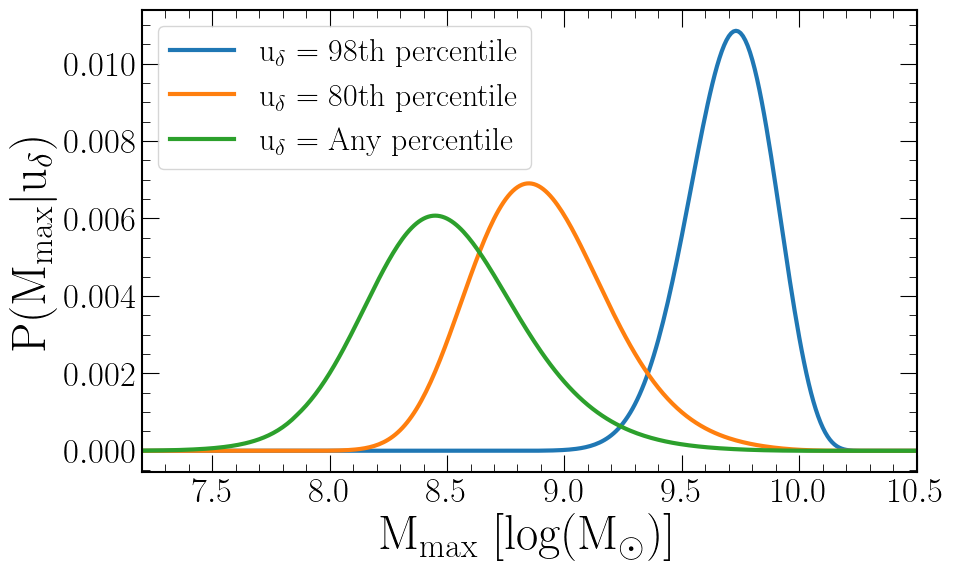

In [73]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{u}_{\delta}$'+' = '+sigl + ' percentile')
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
# fig.savefig('paper/demo_dists.png', dpi = 200, bbox_inches = 'tight')

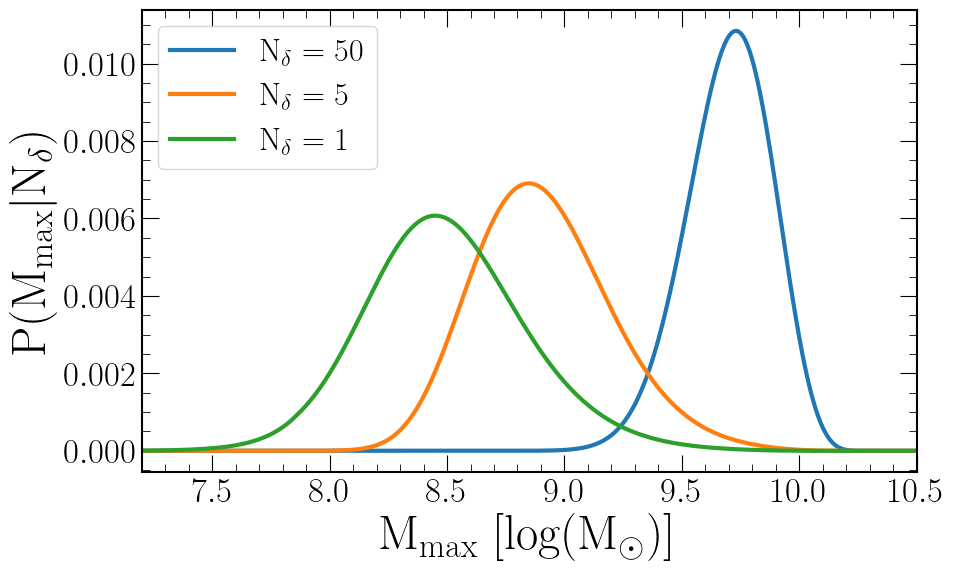

In [ ]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['50', '5', '1']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{N_{\delta}}$'+' = '+sigl)
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{N_{\delta}})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
fig.savefig('paper/demo_NOD.png', dpi = 200, bbox_inches = 'tight')

3508
[0, 92, 173, 335, 497, 659, 821, 3500]


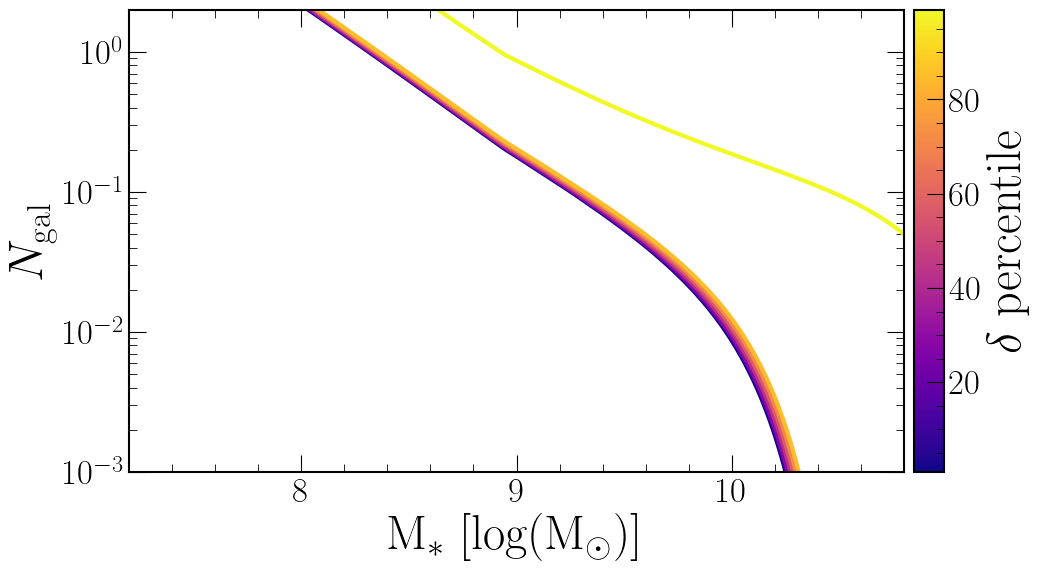

In [101]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp

lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sig_labels = ['50', '5', '1']
sig = 0
with h5py.File(f'../evstats/data/test_OD_fast_{sig}.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
fig, ax = plt.subplots(figsize = (10,6))
nsamp = 50
zidx = 0
smf = smfs[zidx]
print(len(smf.T))
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-2::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
idxs = [0, 92, 173, 335, 497, 659, 821, 1095]
idxs = [0, 92, 173, 335, 497, 659, 821, 3500]


print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
fig
# fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

[5, 92, 173, 335, 497, 659, 821, 902, 980]


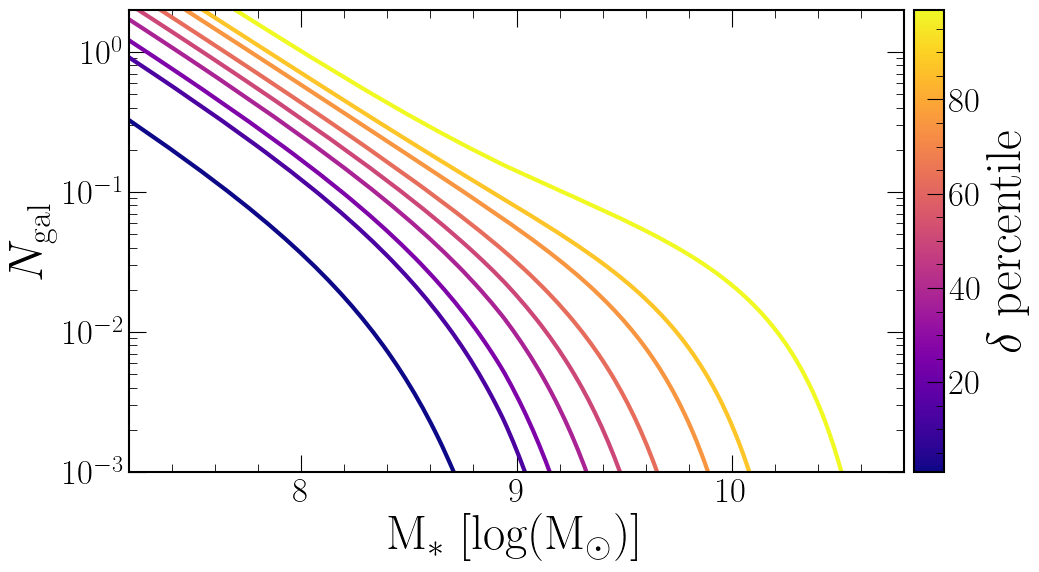

In [162]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
fig, ax = plt.subplots(figsize = (10,6))
nsamp = 81
zidx = 0
smf = smfs[zidx]
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-70::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
fig
fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

1000
[30, 100, 300, 500, 750, 975, 998]


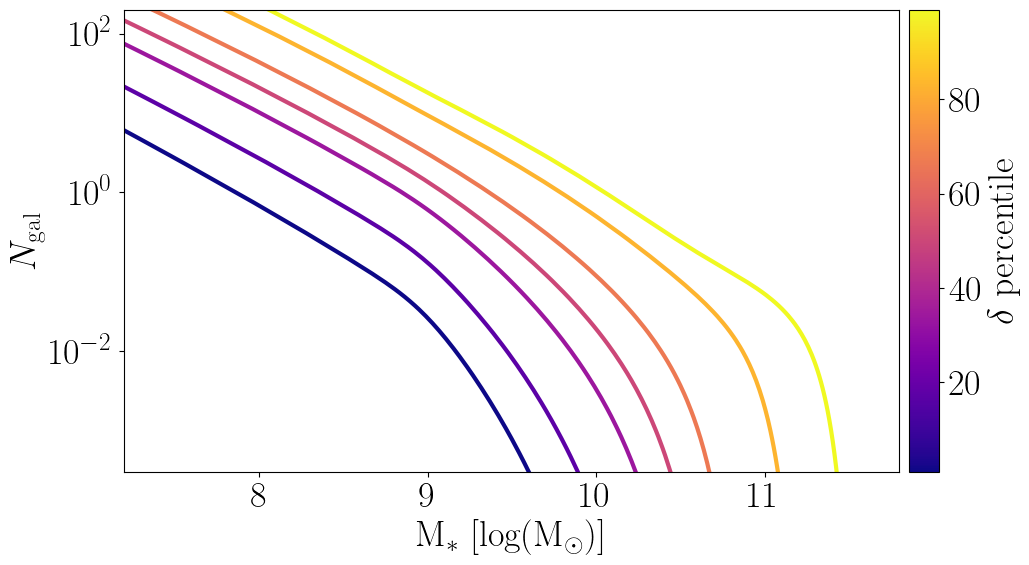

In [134]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
from scipy.ndimage import gaussian_filter1d, gaussian_filter

lw = 3
fig, ax = plt.subplots(figsize = (10,6))

sig_labels = ['50', '5', '1']
sig = -0
with h5py.File(f'../evstats/data/test_OD_fast_{sig}.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
nsamp = 50
zidx = 0
smf = smfs[zidx]
print(len(smf.T))
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-2::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
idxs = [0, 92, 173, 335, 497, 659, 821, 1095]
idxs = [9500, 9600, 9700, 9800, 9900]

idxs = [30, 100, 300, 500, 750, 975, 998]


print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 11.8), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$', ylim = (3e-4, 2e2))

# ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
    #    xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
# fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

/var/folders/7n/5d661fr13pz2l_3q38y38nz80000gn/T/ipykernel_27202/1280236104.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(smf[:, 400:]))


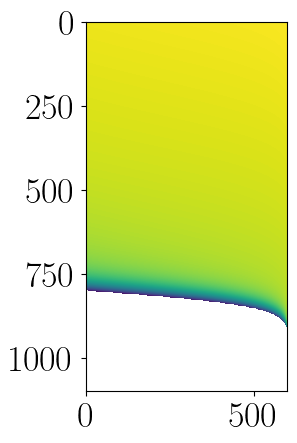

In [132]:
plt.imshow(np.log10(smf[:, 400:]))

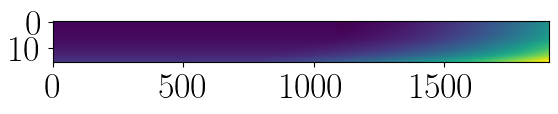

In [66]:
df_loc = '../evstats/dfs/scaled_3.21_0.073.csv' 
# df_loc = '../evstats/dfs/base_cv.csv'
# df_loc = '../calculate_sigma_cv/dfs/base_cv.csv'  
cv_df = pd.read_csv(df_loc)
masses = cv_df.columns[4:]
masses = masses.astype('float')

plt.imshow(cv_df[cv_df.columns[4:]], aspect = 10)

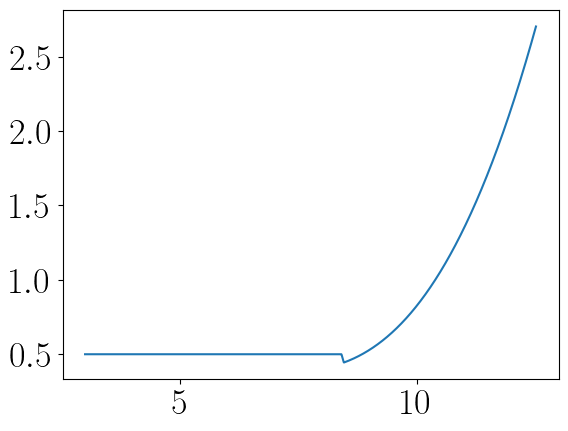

In [70]:
plt.plot(masses, cv_df[cv_df.columns[4:]].iloc[2])

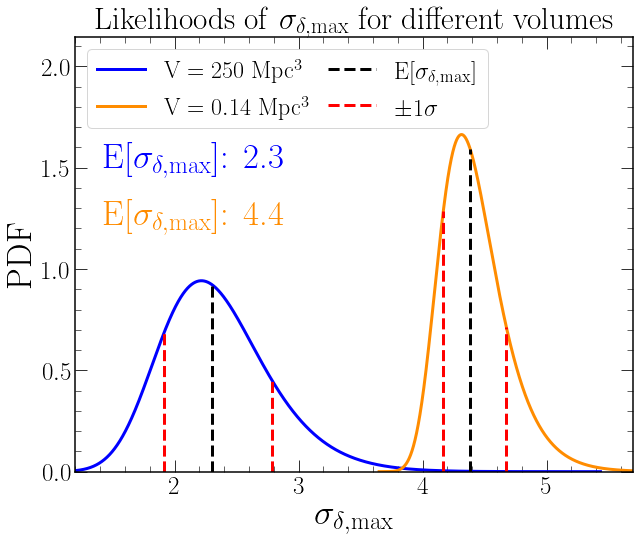

In [211]:
#  N_sky * f_sky * pow(F_sky, N_sky - 1.)

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
csmall = 'darkorange' 

l = 1e-5
fs = 35

N = 65
x = np.linspace(-7, 7, int(1e7))
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]

ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=250~Mpc^3}$')
ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.7), xycoords = 'axes fraction',\
            color = cbig, fontsize = fs)


N = 119145.0238214981
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=0.14~Mpc^3}$')

ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\mathrm{E[\sigma_{\delta,\mathrm{max}}]}$')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\pm 1\sigma$')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.set(xlim = (1.2, 5.7), ylim = (0, max(evs)*1.29), xlabel = r'$\sigma_{\delta, \mathrm{max}}$', \
       ylabel = r'$\mathrm{PDF}$', title = r'$\mathrm{Likelihoods~of~\sigma_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.57), xycoords = 'axes fraction',\
            color = csmall, fontsize = fs)

ax.legend(ncols = 2, loc = 'upper left', fontsize = 24, columnspacing = 0.8)
fig.savefig('paper/EVS_sigma.png', bbox_inches = 'tight', dpi = 200)

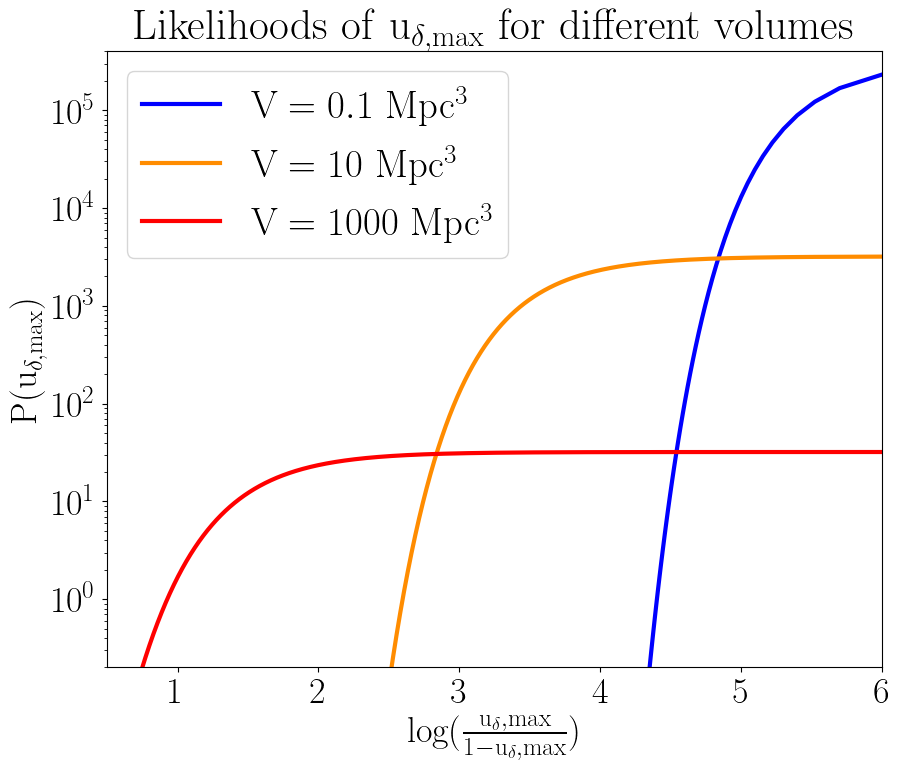

In [49]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 1e6
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

ax.plot(logit(x[evs>l]), evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=0.1~Mpc^3}$')


N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
ax.plot(logit(x[evs>l]), evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V=10~Mpc^3}$')

N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
ax.plot(logit(x[evs>l]), evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=1000~Mpc^3}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'log', ylim = (2e-1, 4e5), xlim = (0.5, np.log10(nsamp)), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig.savefig('paper/EVS_percentile_update.png', bbox_inches = 'tight', dpi = 200)

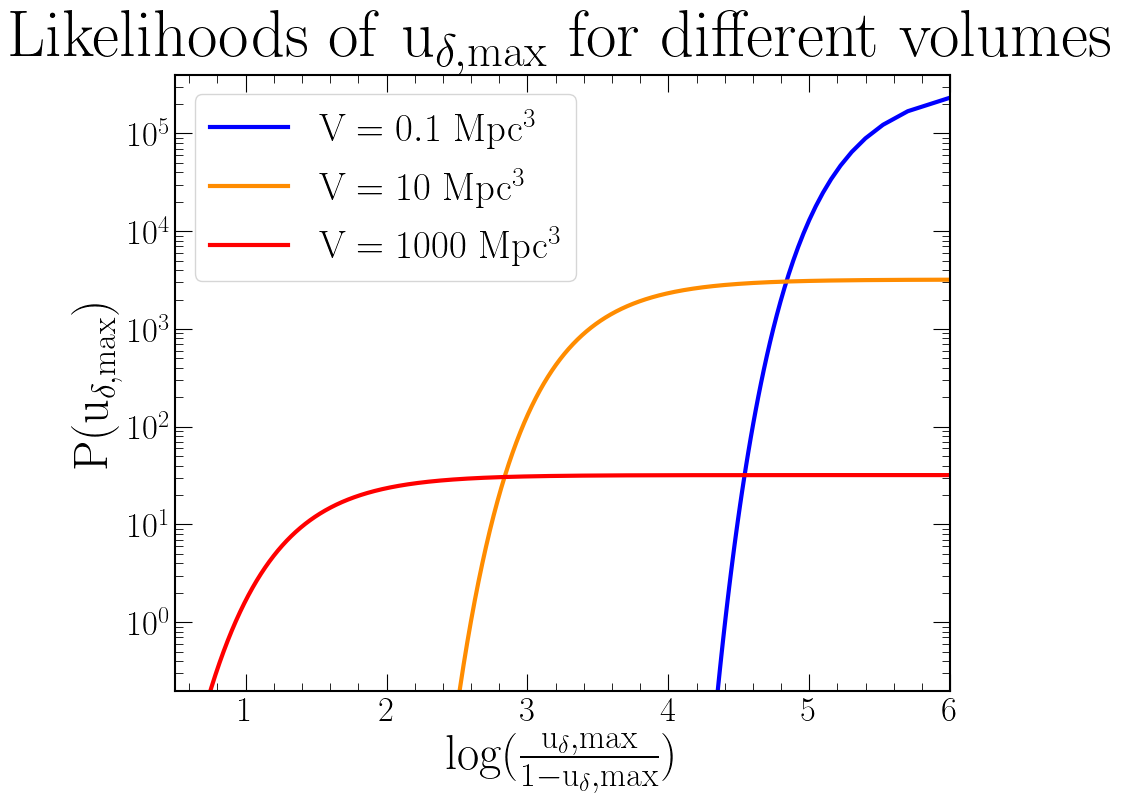

In [6]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 1e6
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

ax.plot(logit(x[evs>l]), evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=0.1~Mpc^3}$')


N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(logit(x[evs>l]), evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V=10~Mpc^3}$')

N *= 1/100 
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(logit(x[evs>l]), evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=1000~Mpc^3}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'log', ylim = (2e-1, 4e5), xlim = (0.5, np.log10(nsamp)), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


python(17787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17898) Malloc

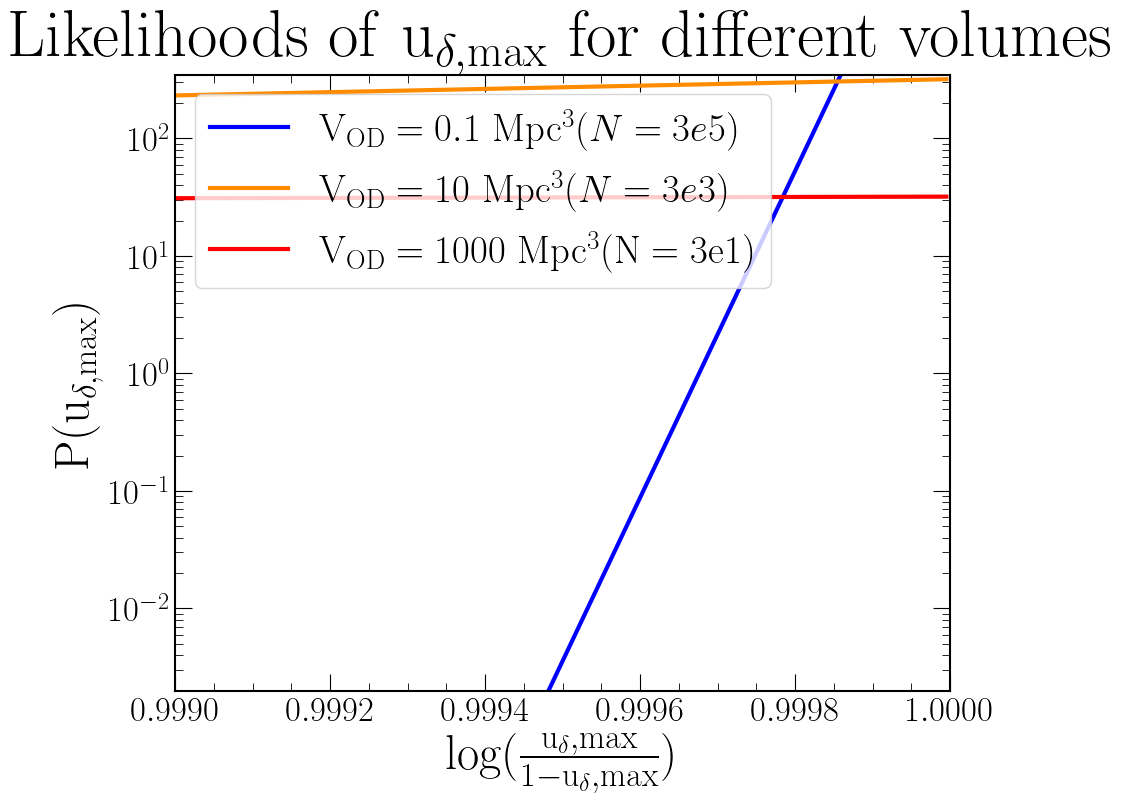

In [61]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 2e5
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))

N *= 1/10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N *= 1/100
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N *= 1/10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'log', ylim = (2e-3, 3.5e2), xlim = (0.999, 1), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


python(52944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


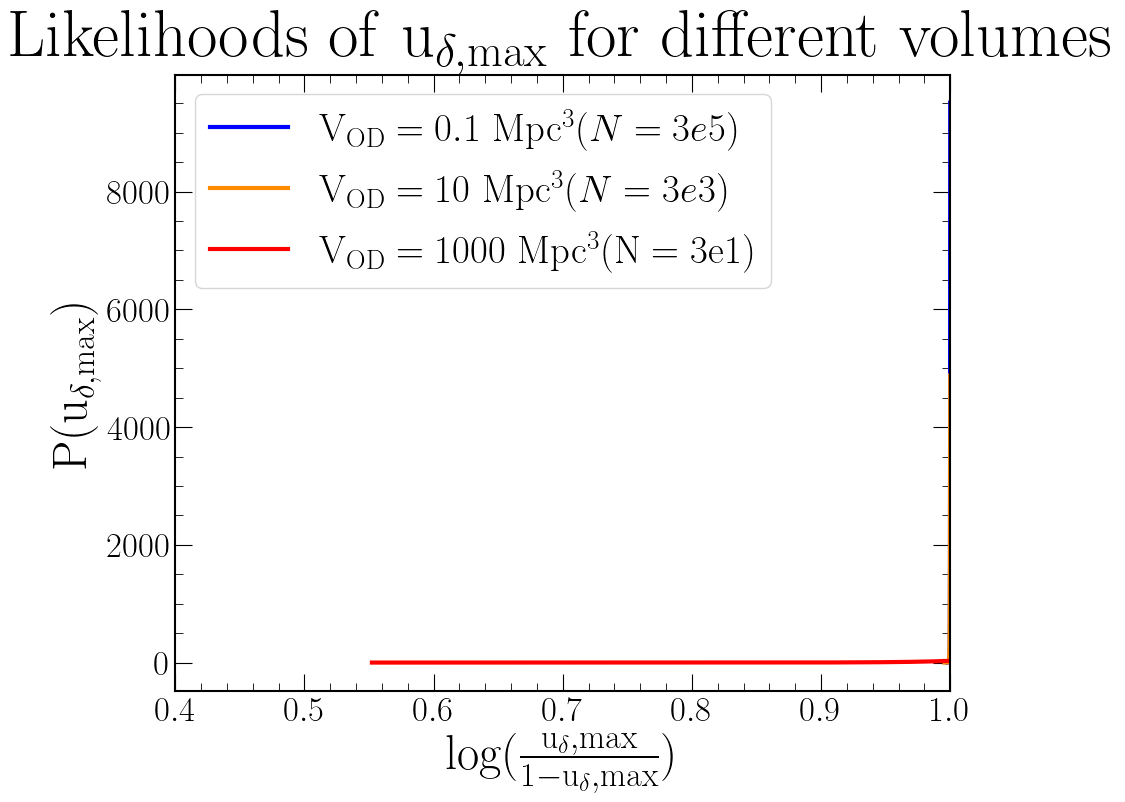

In [ ]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-6
fs = 35

N = 25
nsamp = 2e5
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N = 10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N = 5
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'linear', xlim = (0.4, 1), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


In [36]:
stacked = np.vstack([x, evs0, evs1, evs2])
np.save('EVS_uniform.npy', stacked)

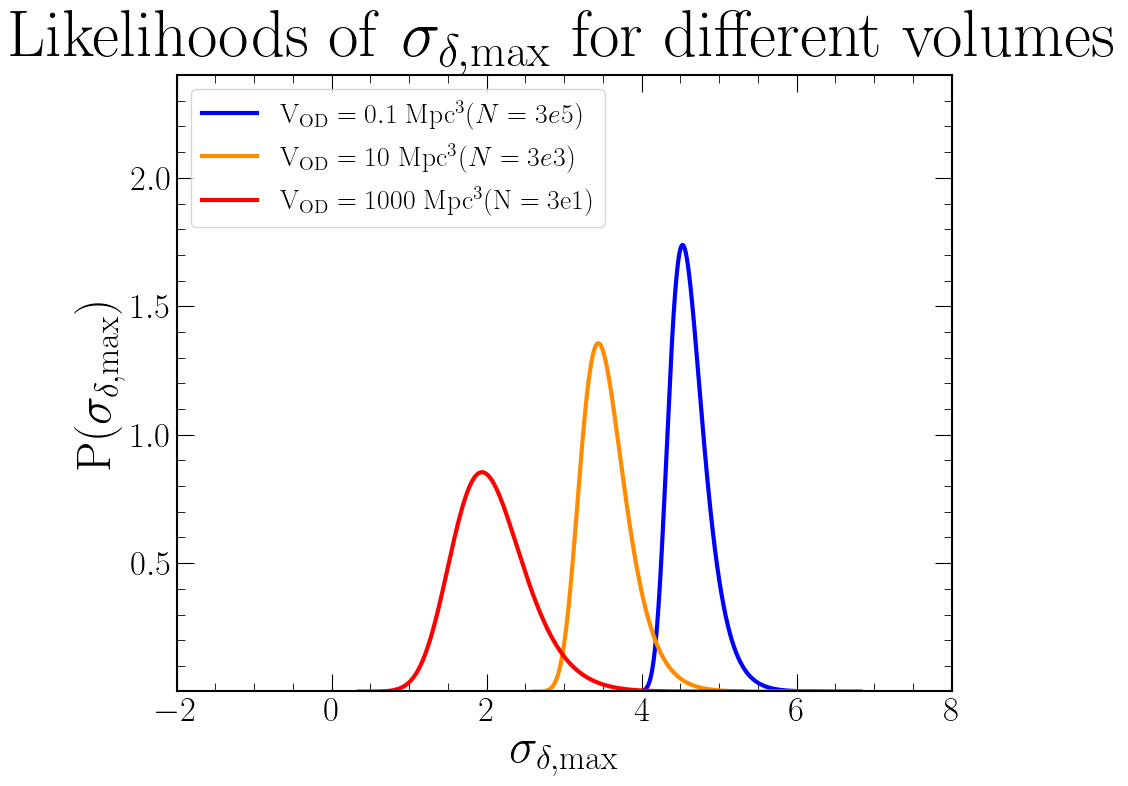

In [47]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 2e5
# x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
x = np.linspace(-10, 10, int(nsamp))


evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)

evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N *= 1/100
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N *= 1/100
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'linear', ylim = (2e-3, 2.4), xlim = (-2, 8), xlabel = r'$\mathrm{\sigma_{\delta,\mathrm{max}}}$',\
       ylabel = r'$\mathrm{P(\sigma_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~\sigma_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 20, columnspacing = 0.8)
fig


In [5]:

import h5py        
with h5py.File(f'../evstats/data/lowz_big_OD_fast_0.h5','r') as hf: 
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

In [10]:
np.sum(smfs[0], axis = 1)

array([29029284., 29029284., 28368776., ...,        0.,        0.,
              0.], dtype=float32)

10.805


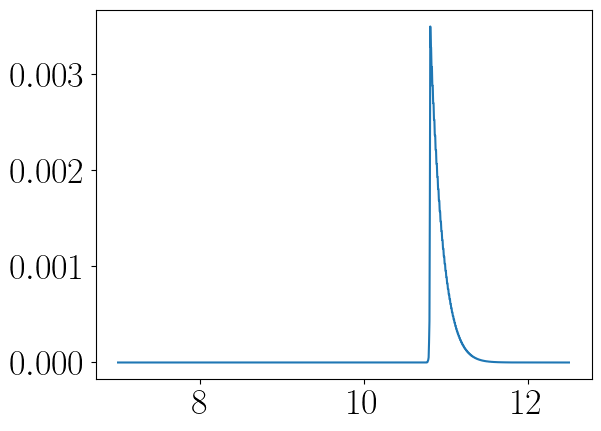

In [23]:
smf = np.mean(smfs[0], axis = 1)*34
N = np.sum(smf)
f = smf/N
F = np.cumsum(smf)
F = F/N
phi_max = N*f*pow(F, N-1)
print(log10m[:-1][np.argmax(phi_max)] )
plt.plot(log10m[:-1], phi_max)

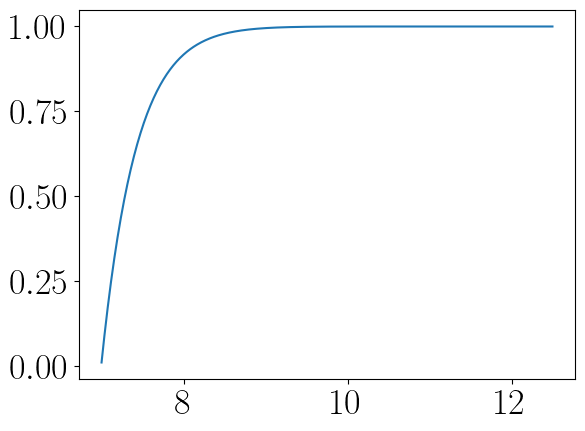

In [27]:
plt.plot(log10m[:-1], F)


/var/folders/7n/5d661fr13pz2l_3q38y38nz80000gn/T/ipykernel_1736/2564516216.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(log10m[:-1], np.log10(smf))


(-1.0, 10.0)

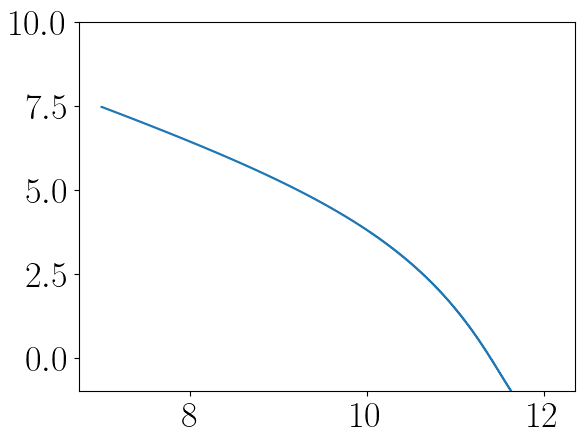

In [21]:
plt.plot(log10m[:-1], np.log10(smf))
plt.ylim(-1, 10)

11.065


(10.0, 12.0)

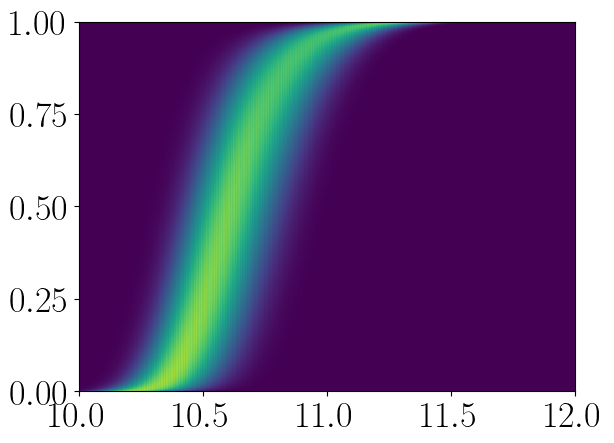

In [342]:
plt.pcolormesh(log10m[:-1], np.linspace(0,1, len(evs_OD)), phi_maxs[0].T, shading='nearest')
print(log10m[:-1][np.argmax(phi_max_conv[0])] )
plt.xlim(10,12)

7000

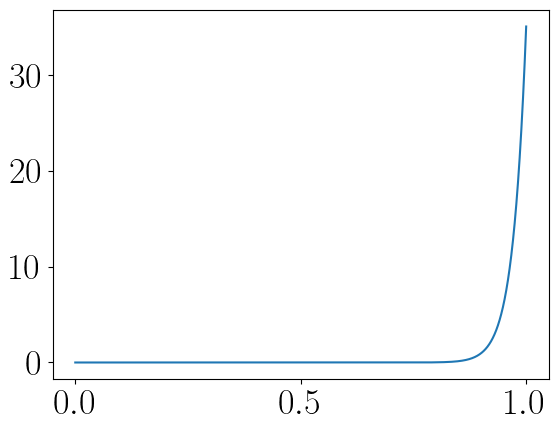

In [337]:
plt.plot(np.linspace(0,1, len(evs_OD)), evs_OD)
len(evs_OD)